In [45]:
import pulsestreamer
import pyvisa
import numpy as np
import sys
from importlib import reload
import matplotlib.pyplot as plt
from zhinst.toolkit import Session,  Waveforms
from zhinst.toolkit import CommandTable

directory_path = r"C:\\Users\\LiLabDesktop\\Desktop\\Sumukh\\LiLabMeasurements\\LiLabMeasurements\\dev"
sys.path.append(directory_path)


import AWG_Measurements
reload(AWG_Measurements)


directory_path2 = "C:\\Users\\LiLabDesktop\\Desktop\\Sumukh\\LiLabMeasurements\\LiLabMeasurements\\main"
sys.path.append(directory_path2)

### Initialize all instruments for use

In [46]:
# PulseStreamer
pulsestreamer_ip = '169.254.8.2'
ps = pulsestreamer.PulseStreamer(pulsestreamer_ip)
ps.reset()

# Function Generator
rm = pyvisa.ResourceManager()
sg386 = rm.open_resource('GPIB0::27::INSTR')
sg386.write('ENBR 1')

# AWG
AWG_id='DEV9175'
AWG_server_host = 'localhost'
session = Session(AWG_server_host)
### connect to device
device = session.connect_device(AWG_id)
AWG_INDEX = 0 #use channel 1&2 for 2*2
awg = device.awgs[AWG_INDEX]

# Resource Manager
rm = pyvisa.ResourceManager()

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.6.2
Client software: v1.7.0
Your client software is more up to date than the Pulse Streamer 8/2 firmware. We recommend updating the firmware of your Pulse Streamer 8/2.
For detailed information visit https://www.swabianinstruments.com/pulse-streamer-8-2/downloads/ or contact support@swabianinstruments.com


In [49]:
AWG_rabi_config = {
'position':[120,175], # Location of measurement
'scale': 8,
'samples_per_axis': 201,
'scan_area': 1, # In pixels
'aomvolt': 0.5, # Voltage to set AOM to


'nu_IQ': 244.1, # IQ modulation frequency in MHz
'IQ_amplitude': 0.9, # Amplitude of the IQ modulation
'freq': 2.85e9, # in Hz, Drive frequency of the qubit
'mw_power': -6, # in dBm

'tau_step': 1.25e-3, # in microseconds
'tau_start': 2.5e-3, # in microseconds
'n_points': 100, # number of tau points
'sequence_repetitions': 500, # number of times to repeat the pulse sequence for each tau point
'num_avgs': 1000,

'init_t': 5-0.96, # microseconds
'readout_t': .5, # microseconds
'wait_t': 2.3, # microseconds
'delay_t': 0.960, # microseconds
}

In [51]:
awg_measurement = AWG_Measurements.AWGMeasurement(AWG_rabi_config, ps, sg386, awg, rm)

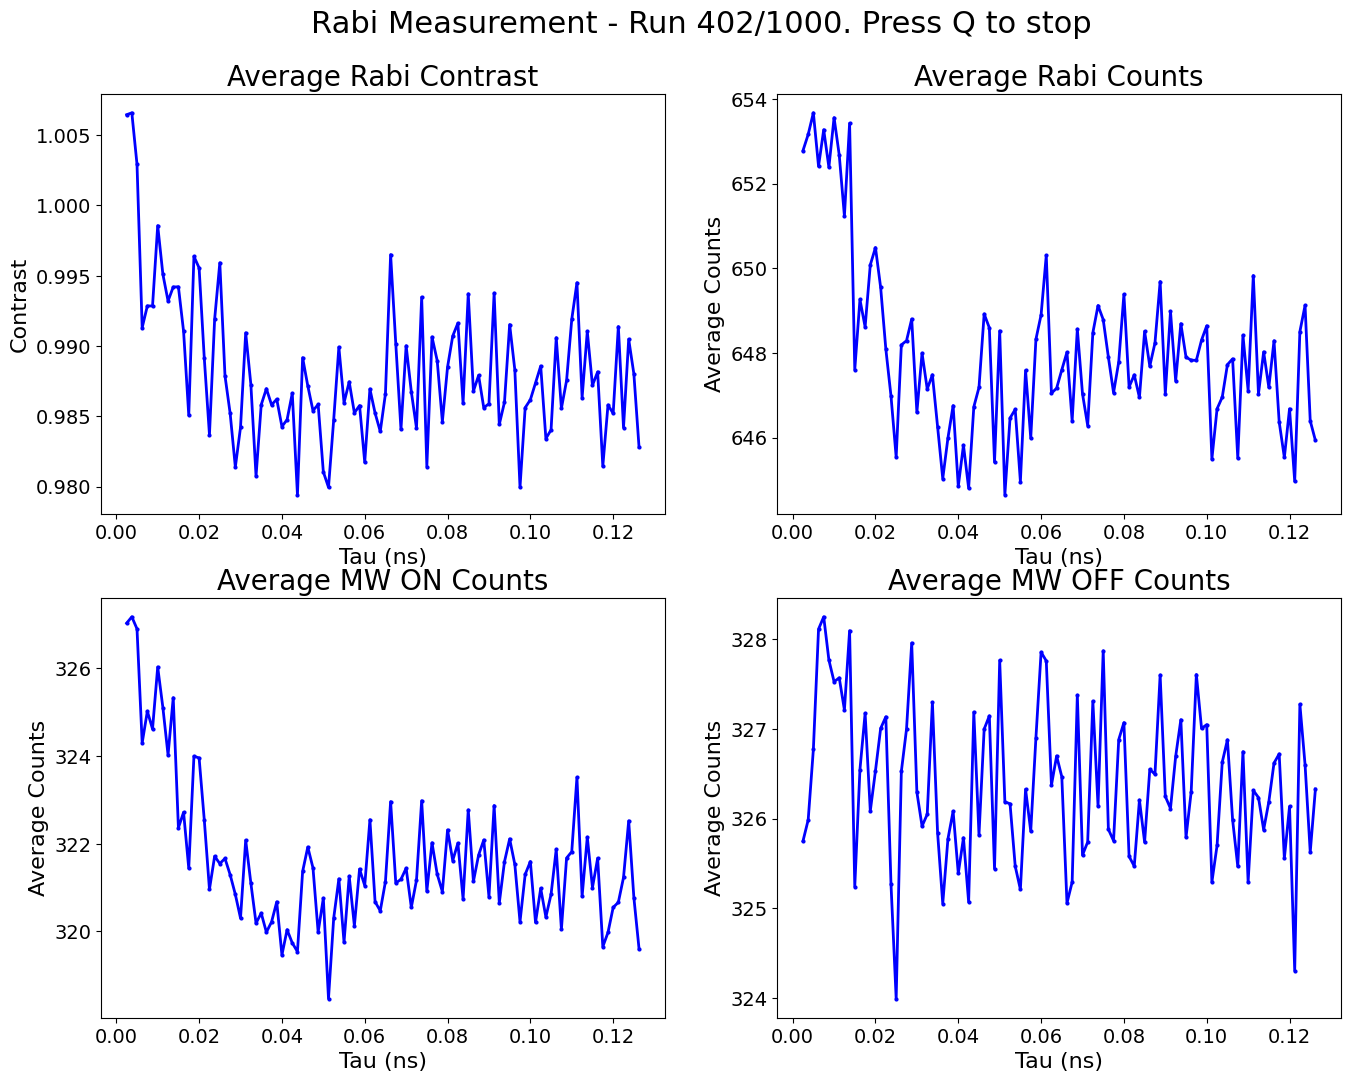

 40%|████      | 402/1000 [07:21<10:46,  1.08s/it]

In [ ]:
tau_range, avg_contrast, all_contrast, avg_counts, all_counts, all_data =awg_measurement.run_rabi_sweep()

In [33]:
all_data.shape

(1000, 100000)

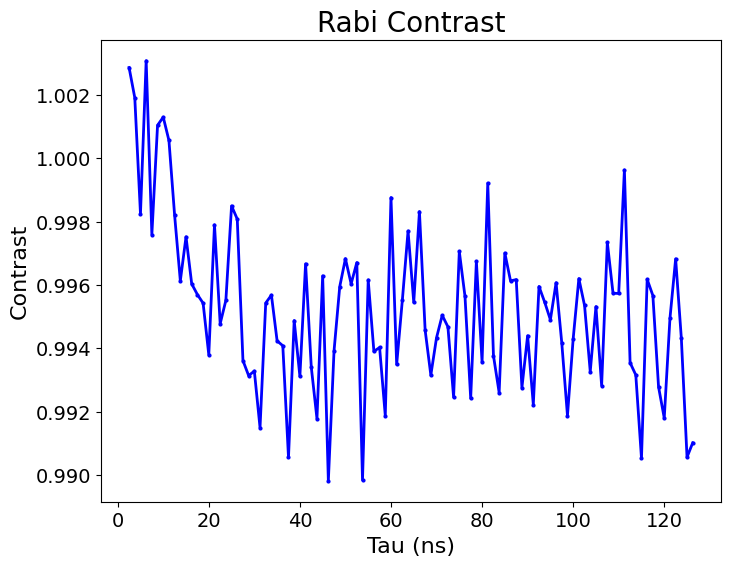

In [42]:
all_data_for_testing = all_data

def plot_this_xy(xdata, ydata, ax, title, xlabel, ylabel, linestyle = '-', color = 'blue', linewidth = 2, marker = 'o', markersize = 2):
    ax.set_title(title, fontsize=20)
    ax.plot(xdata, ydata, linestyle = linestyle, color = color, linewidth = linewidth, marker = marker, markersize = markersize)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)


def rabifixer(data):
    all_contrast = np.zeros(data.shape)
    avg_contrast = np.zeros(100)
    all_counts = np.zeros(data.shape)
    # all_data2 = np.zeros((self.config['num_avgs'],self.config['n_points'] * 2 * self.config['sequence_repetitions']))
    # avg_counts = np.zeros(len(tau_range))
    avg_mw_on = np.zeros(100)
    avg_mw_off = np.zeros(100)

    for j in range(1000):
        counts = data[j,:]
        all_data = counts.reshape(50000, 2)
        mw_off = all_data[:,1].reshape((500,100)).sum(axis=0)
        mw_on = all_data[:,0].reshape((500,100)).sum(axis=0)
        # mw_off = np.array(counts[:self.config['n_points']]) # First half no MW
        # mw_on = np.array(counts[self.config['n_points']:]) # Second half with MW
        
        avg_contrast += mw_on/(mw_off)
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_this_xy(tau_range*1e3, avg_contrast/1000, ax, 'Rabi Contrast', 'Tau (ns)', 'Contrast', linestyle = '-', color = 'blue', linewidth = 2, marker = 'o', markersize = 2)


rabifixer(all_data_for_testing)